# AIML331 Assignment 1
## crowelenn | 300607096

In [3]:
import numpy as np

## Question 1: Camera Problem

**1.1** Your pinhole camera is at [X, Y, Z] = [0, 0, −10]] and sits on a horizontal table. It is pointing 30 degrees to the right relative to the origin of the world coordinates. Compute the [R, t] matrix converting world coordinates to camera coordinates.

In [4]:
from numpy import cos, sin

In [5]:
yaw = np.radians(30)
pitch = np.radians(0)
roll = np.radians(0)

a = yaw
b = pitch
y = roll

In [6]:
R = np.array(
    [
        [cos(b)*cos(y), sin(a)*sin(b)*cos(y) - cos(a)*sin(y), cos(a)*sin(b)*cos(y) + sin(a)*sin(y)],
        [cos(b)*sin(y), sin(a)*sin(b)*sin(y) + cos(a)*cos(y), cos(a)*sin(b)*sin(y) - sin(a)*cos(y)],
        [-sin(b), sin(a)*cos(b), cos(a)*cos(b)]
    ])

In [7]:
t = np.array([[0, 0, -10]]).T

In [8]:
Rt = np.concatenate((R, t), axis=1)
Rt = np.concatenate((Rt, [[0, 0, 0, 1]]), axis=0)

In [11]:
Rt

array([[  1.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.8660254,  -0.5      ,   0.       ],
       [ -0.       ,   0.5      ,   0.8660254, -10.       ],
       [  0.       ,   0.       ,   0.       ,   1.       ]])

**1.2** Your camera has f = 0.1 (focal length, as used in pinhole camera). Using homogeneous coordinates compute the equation of a line on the projective plane that goes through the points that correspond to [0, 1, 0] and [0, 0, 1] in the world coordinates

In [12]:
f = 0.1

In [13]:
K = np.array([[f, 0, 0, 0],
              [0, f, 0, 0],
              [0, 0, 1, 0]])

In [20]:
world_1 = np.array([[0, 1, 0, 1]]).T # first world coordinates in the homogenous space
world_2 = np.array([[0, 0, 1, 1]]).T # second world coordinates in the homogenous space

In [34]:
proj_1 = K @ Rt @ world_1 # pass the first world coordinate through Rt and K

In [35]:
proj_2 = K @ Rt @ world_2 # pass the second world coordinate through Rt and K

In [37]:
proj_2

array([[ 0.       ],
       [-0.05     ],
       [-9.1339746]])

In [27]:
proj_1 /= proj_1[-1]
proj_2 /= proj_2[-1]

In [33]:
proj_2

array([[-0.        ],
       [ 0.00547407],
       [ 1.        ]])

In [30]:
# the cross product of coordinates in the homogeneous projected space is the line through the points on the projective plane.
np.cross(proj_1.T, proj_2.T)

array([[-0.01459013,  0.        , -0.        ]])

This is a vertical line as the y-component is 0.

## Question 2: Checkerboard problem

**2.1** Find an image on-line that displays a checkerboard (provide source website).
Convert to gray-scale if it is colour

Image source: https://static.vecteezy.com/system/resources/thumbnails/000/639/981/small_2x/Black_and_white_checkered_pattern.jpg

I am using the pillow (PIL) package exclusively to load the image and convert it to a numpy array.


In [41]:
from PIL import Image

In [42]:
checkerboard = np.array(Image.open("check.jpg").convert("L"))

In [43]:
# checking that the checkerboard image has loaded correctly
checkerboard.shape

(400, 400)

This image is already in greyscale so doesn't need to be converted.

**2.2** Write a program to compute the histogram and cumulative probability function
of the image and display result.

In [53]:
import matplotlib.pyplot as plt

In [118]:
def find_historgam(np_image):
    hist = np.zeros(256)

    for i in np_image.reshape(-1):
        hist[i] += 1

    return hist

In [115]:
def find_cdf(np_image):
    hist = find_historgam(np_image)
    im_total = np_image.reshape(-1).shape[0]
    cdf = np.zeros(256)

    for i in range(256):
        cdf[i] = hist[0:i+1].sum() / im_total

    return cdf

Text(0.5, 1.0, 'Histogram of the checkerboard image')

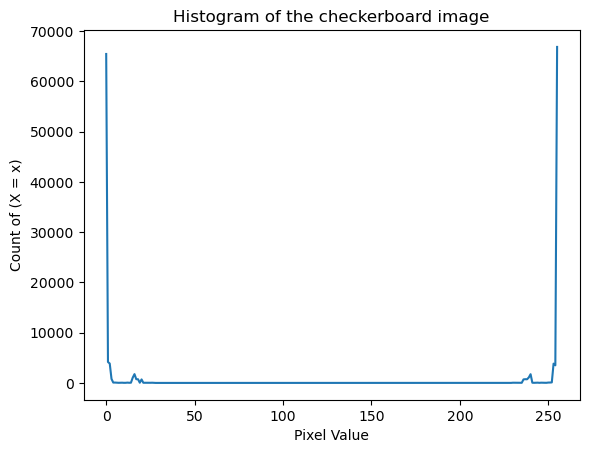

In [133]:
plt.plot(find_historgam(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the checkerboard image")

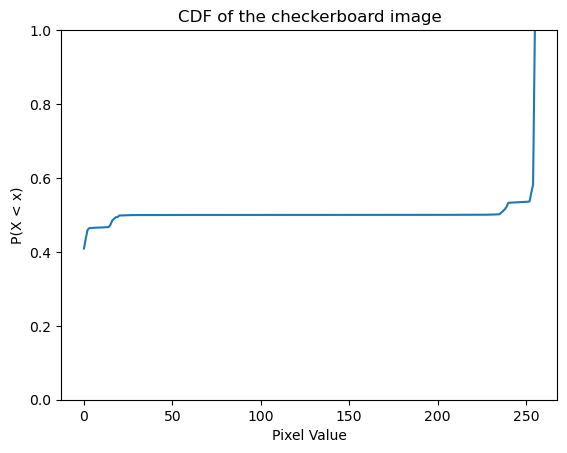

In [134]:
plt.plot(find_cdf(checkerboard))
plt.xlabel("Pixel Value")
plt.ylabel("P(X < x)")
plt.ylim(0, 1)
plt.title("CDF of the checkerboard image")
plt.show()

**2.3** Write a program to low-pass filter (smooth) the image in the spatial domain.
You can select the filter.

I am going to use a box filter.

In [44]:
kernel = np.ones((10, 10)) # create a box filter (a 10x10 matrix of 1's)

In [54]:
def do_convolution(image, kernel):
    N, M = kernel.shape # dimensions of the kernel
    output_image = np.zeros(image.shape) # 'copy' the convolution results to this image
    kernel_sum = np.sum(kernel) # add up the kernel value - this is just for normalization

    # we need half the kernel width added to each side of the image
    # otherwise the filter can't be passed over the edges of the image
    # // does floor division - which is useful here because the pad values need to be integers
    pad_h = N // 2
    pad_w = M // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # iterate through each pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # implementing the formula for a convolution
            output_image[i, j] = np.sum(kernel * padded_image[i:i+N, j:j+M]) / kernel_sum

    # cast to integers and return the image with the convolution applied
    return output_image.astype(np.uint8)

In [55]:
output = Image.fromarray(do_convolution(checkerboard, kernel))

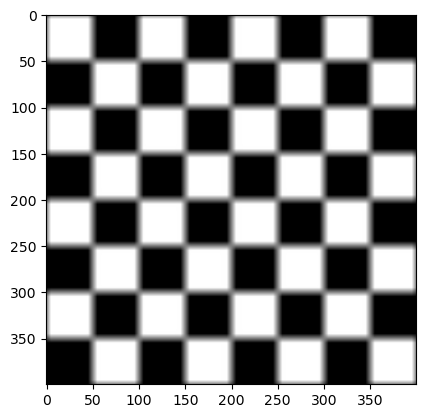

In [56]:
plt.imshow(output, cmap='gray')

**2.4** Explain if the low-pass filter you selected is separable.

A separable kernel can be reduced to a product of two vectors (1D filters). My filter is a \(10 \times 10\) matrix of 1's as follows:

\[
\begin{bmatrix}
    1       & 1 & 1 & \dots & 1 \\
    1       & 1 & 1 & \dots & 1 \\
    \vdots & \vdots & \ddots \\
    1       & 1 & 1 & \dots & 1
\end{bmatrix}
\]

This can be expressed as:

\[
\begin{bmatrix} 1 & 1 & 1 & \cdots & 1 \end{bmatrix}
\cdot
\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\]





In [58]:
kernel = kernel/100

In [89]:
# to avoid having the periodic nature of DFT causing the right hand side of the image
# getting padded on the left hand side (and the same for the top/bottom), the image can be
# padded to double its original size, with black (0's) in the following 400 pixels on each
# side of the image.
padded_image = np.zeros((800, 800))
padded_image[:400, :400] = checkerboard

In [92]:
# building the kernel - it must be the same size as the image
padded_kernel = np.zeros((800, 800))
# place the box filter in the middle of the new kernel
padded_kernel[0:10, 0:10] = kernel

# calculate the DFT's of both the image and the kernel
Im_fft = np.fft.fft2(padded_image)
Kernel_fft = np.fft.fft2(padded_kernel)

In [93]:
# element-wise multiplication
# multiplication in the frequency domain is the same as convolution in the signal domain
frequency_convolution = np.multiply(Im_fft, Kernel_fft)

In [94]:
# take the real component of the inverse of the DFT pairwise multiplication
image_dft_convolution_padded = np.fft.ifft2(frequency_convolution).real

In [109]:
image_dft_convolution = image_dft_convolution_padded[5:405, 5:405]

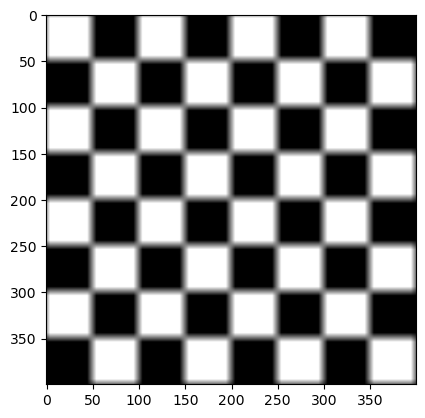

In [110]:
plt.imshow(image_dft_convolution, cmap='gray')

**2.6** Compute the histogram of the low-pass filtered checkerboard image.

Text(0.5, 1.0, 'Histogram of the checkerboard image')

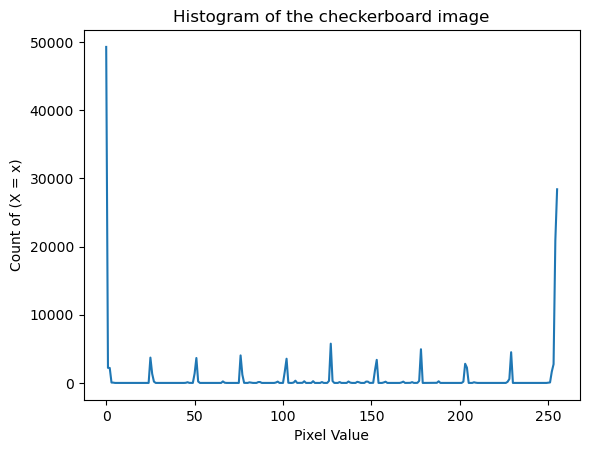

In [145]:
plt.plot(find_historgam(img_test.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the checkerboard image")

**2.7** Using cumulative distribution functions, convert your low-pass filtered checkerboard image to have a uniform probability of intensity levels.

In [111]:
# this isn't used. But this is the formula for finding the cdf.
# I kept this here to give some context to 'cdf_inverse', which
# is the inverse of this function.
def cdf_uniform(x):
    return x/255

In [112]:
def cdf_inverse(x):
    return 255*x

In [116]:
def map_to_cdf(image, cdf_inv):
    image_copy = image.copy()
    intensities_map = cdf_inv(find_cdf(image.astype(np.uint8)))

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_copy[i, j] = intensities_map[image[i, j]]


    return image_copy

In [119]:
# TODO: Check that the indexing isn't causing the black regions?
image_flattened = map_to_cdf(checkerboard.astype(np.uint8), cdf_inverse)

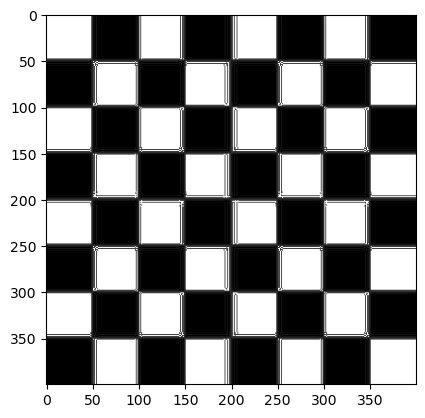

In [123]:
# check why is black still appearing?
plt.imshow(image_flattened, cmap='gray')

In [122]:
image_flattened

array([[255, 255, 255, ..., 104, 104, 104],
       [255, 255, 255, ..., 104, 104, 104],
       [255, 255, 255, ..., 104, 104, 104],
       ...,
       [104, 104, 104, ..., 255, 255, 255],
       [104, 104, 104, ..., 255, 255, 255],
       [104, 104, 104, ..., 255, 255, 255]], dtype=uint8)

Text(0.5, 1.0, 'Histogram of the flattened checkerboard image')

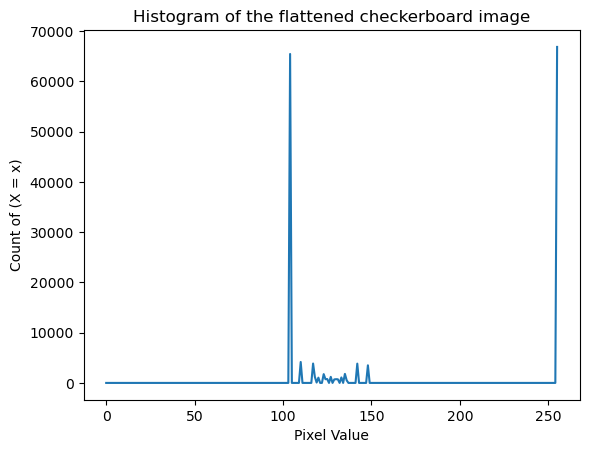

In [121]:
plt.plot(find_historgam(image_flattened.astype(np.uint8)))
plt.xlabel("Pixel Value")
plt.ylabel("Count of (X = x)")
plt.title("Histogram of the flattened checkerboard image")